In [80]:
# Importing Libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Reshape,Conv2DTranspose,Add,Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,Layer)
from tensorflow.keras.optimizers import Adam

In [81]:
# Data Preparation

In [82]:
(x_train,_),(x_test,_) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train,x_test],axis=0)
mnist_digits = np.expand_dims(mnist_digits,-1).astype("float32")/255

In [83]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [84]:
len(dataset)

70000

In [85]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [86]:
train_dataset = (
      dataset
      .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE)
)

In [87]:
train_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [88]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1])) 

In [89]:
# Encoder

In [90]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(64,3,activation='relu',strides=2,padding='same')(encoder_inputs)
x = Conv2D(128,3,activation='relu',strides=2,padding='same')(x)

x = Flatten()(x)
x = Dense(16,activation='relu')(x)

mean = Dense(LATENT_DIM)(x)
log_var = Dense(LATENT_DIM)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var],name='encoder')
encoder_model.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 64)   640         ['input_11[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 7, 128)    73856       ['conv2d_8[0][0]']               
                                                                                                  
 flatten_4 (Flatten)            (None, 6272)         0           ['conv2d_9[0][0]']               
                                                                                            

In [91]:
#Decoder

In [93]:
latent_inputs = Input(shape=(LATENT_DIM,))

x = Dense(7*7*64,activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(128,3,activation='relu',strides=2,padding='same')(x)
x = Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)

decoder_output = Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_22 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_19 (Conv2D  (None, 28, 28, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 28, 28, 1)        577 

In [94]:
vae_input = Input(shape=(28,28,1),name='vae_input')
x = encoder_model(vae_input)
output = decoder_model(x)
vae = Model(vae_input,output,name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 vae_input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          174932      ['vae_input[0][0]']              
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    157633      ['encoder[0][0]',                
                                                                  'encoder[0][1]',              

In [95]:
OPTIMIZER = Adam(learning_rate=1e-3)
EPOCHS = 30

In [96]:
def custom_loss(y_true,y_pred,mean,log_var):
    
    loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis = (1,2)))
    loss_reg = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)),axis = 1))
    return loss_rec+loss_reg
    

In [97]:
class VAE(tf.keras.Model):
    def __init__(self,encoder_model,decoder_model):
        super(VAE,self).__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
        self.loss_tracker = tf.keras.metrics.Mean(name = 'loss')
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self,x_batch):
        with tf.GradientTape() as recorder:
            z,mean,log_var = self.encoder(x_batch)
            y_pred = self.decoder(z)
            y_true = x_batch
            loss = custom_loss(y_true,y_pred,mean,log_var)
        partial_derivatives = recorder.gradient(loss,self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivatives,self.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {'loss':self.loss_tracker.result()}
     

In [98]:
model = VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset,epochs=EPOCHS,batch_size=128,)

Epoch 1/30
547/547 [==============================] - 13s 22ms/step - loss: 206.1971
Epoch 2/30
547/547 [==============================] - 12s 22ms/step - loss: 171.5244
Epoch 3/30
547/547 [==============================] - 12s 23ms/step - loss: 164.2993
Epoch 4/30
547/547 [==============================] - 13s 23ms/step - loss: 160.5932
Epoch 5/30
547/547 [==============================] - 13s 23ms/step - loss: 158.4796
Epoch 6/30
547/547 [==============================] - 13s 23ms/step - loss: 156.9867
Epoch 7/30
547/547 [==============================] - 13s 24ms/step - loss: 155.8479
Epoch 8/30
547/547 [==============================] - 13s 24ms/step - loss: 154.9145
Epoch 9/30
547/547 [==============================] - 13s 25ms/step - loss: 154.1909
Epoch 10/30
547/547 [==============================] - 14s 25ms/step - loss: 153.5461
Epoch 11/30
547/547 [==============================] - 14s 25ms/step - loss: 152.9566
Epoch 12/30
547/547 [==============================] - 14s 25ms

In [104]:
scale = 2
n = 16

In [105]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [106]:
print(grid_x,grid_y)

[-2.         -1.73333333 -1.46666667 -1.2        -0.93333333 -0.66666667
 -0.4        -0.13333333  0.13333333  0.4         0.66666667  0.93333333
  1.2         1.46666667  1.73333333  2.        ] [-2.         -1.73333333 -1.46666667 -1.2        -0.93333333 -0.66666667
 -0.4        -0.13333333  0.13333333  0.4         0.66666667  0.93333333
  1.2         1.46666667  1.73333333  2.        ]


In [107]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


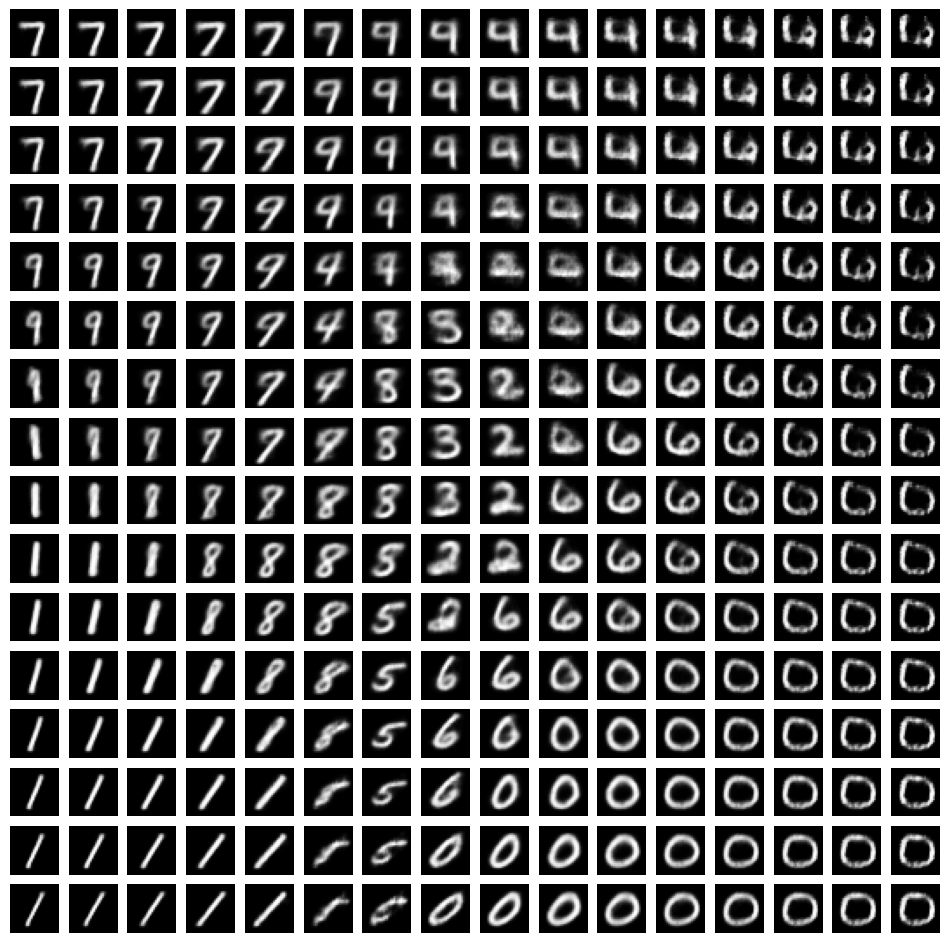

In [108]:
plt.figure(figsize=(12,12))
k = 0
for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n,n,k+1)
        input = tf.constant([[i,j]])
        out = vae.layers[2].predict(input)[0][...,0]
        plt.imshow(out,cmap = 'gray')
        plt.axis('off')
        k = k+1

In [68]:
print(vae.layers[2].predict(tf.constant([[-2,2]]))[0][...,0].shape)

1/1 [==============================] - 0s 18ms/step
(28, 28)


In [110]:

(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 [==============================] - 3s 2ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

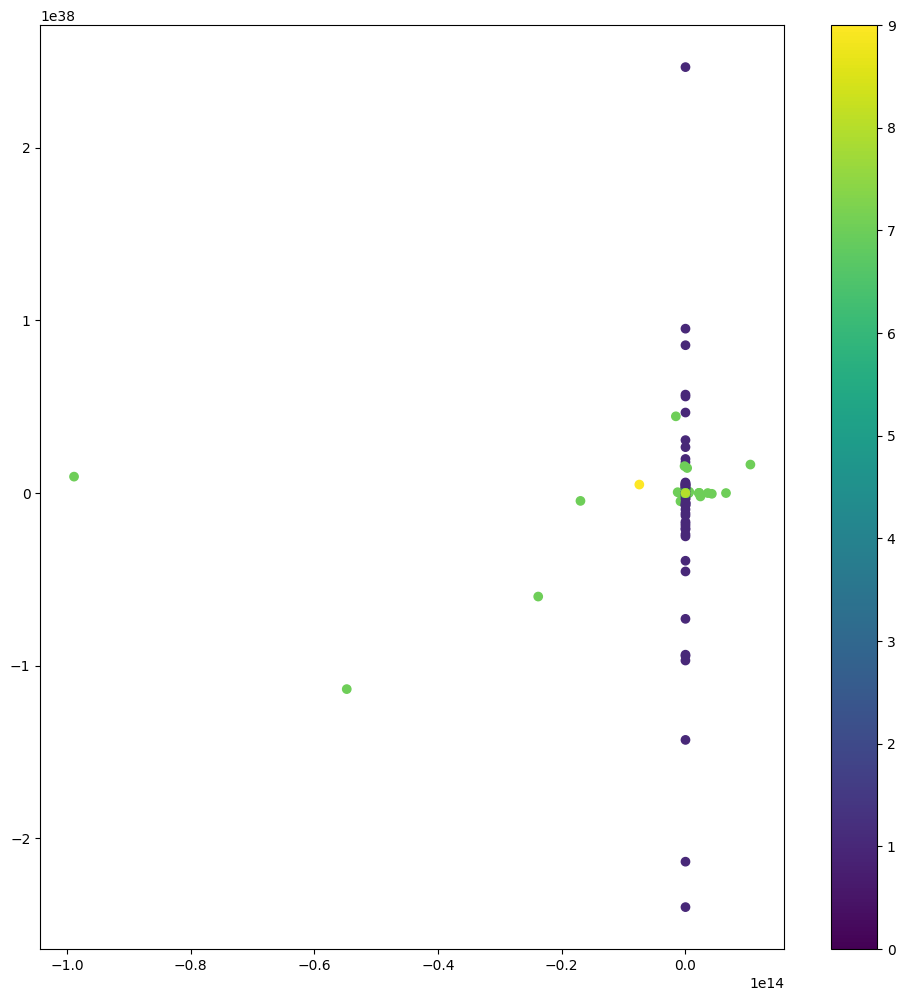

In [111]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show